<a href="https://colab.research.google.com/github/gulis-dev/SatQuant/blob/main/assets/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 🛠️ Step 1: Setup
!rm -rf SatQuant
!git clone https://github.com/gulis-dev/SatQuant.git
%cd SatQuant
!pip install -e . -q

print("✅ Environment Ready!")

Cloning into 'SatQuant'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 52 (delta 12), reused 50 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 7.89 MiB | 31.08 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/SatQuant/SatQuant/SatQuant
  Preparing metadata (setup.py) ... done
Environment Ready!


In [ ]:
# @title 🧪 Step 2: Prepare Data
import os


IMG_PATH = "dota_samples/images/car1.jpg"
LBL_PATH = "dota_samples/labelTxt/car1.txt"

os.makedirs(os.path.dirname(IMG_PATH), exist_ok=True)
os.makedirs(os.path.dirname(LBL_PATH), exist_ok=True)

print(f"✅ Paths ready: {IMG_PATH}")

Paths ready: dota_samples/images/car1.jpg


In [ ]:
# @title 🚀 Step 3: Run Optimization
from satquant import FocusQuantizer, DotaDataset
from ultralytics import YOLO
import os

if not os.path.exists("yolov8n_saved_model"):
    YOLO("yolov8n.pt").export(format='saved_model')

print("⚙️ Converting...")
dataset = DotaDataset("dota_samples/images", "dota_samples/labelTxt", crop_size=640)

FocusQuantizer(model_path="yolov8n_saved_model").convert(
    dataset=dataset,
    output_path="yolov8_satellite_quantized.tflite",
    mode="mixed",
    normalize_input=True
)

print(f"✅ Success! Model saved.")

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (AMD EPYC 7B12)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.77...
ONNX: export success ✅ 1.0s, saved as 'yolov8n.onnx' (12.3 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/SatQuant/SatQuant/SatQuant/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 50.1files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.5...
Saved artifact at 'yolov8n_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  Tensor

🚀 Processing dota_samples/images/car1.jpg...
Original (FP32) Raw Shape: (1, 84, 8400)
TFLite (INT8)  Raw Shape: (1, 84, 8400)
MSE Error: 0.708658


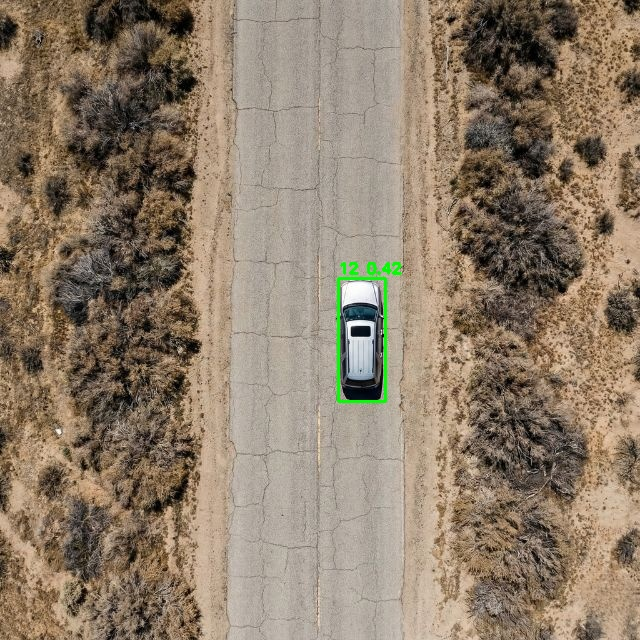

In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
from IPython.display import Image, display

IMG_PATH = "dota_samples/images/car1.jpg"
if not os.path.exists(IMG_PATH):
    print("Missing image. Downloading dummy sample...")
    !curl -L -o $IMG_PATH "https://github.com/ultralytics/yolov5/raw/master/data/images/bus.jpg"

MODEL_SM = "yolov8n_saved_model"
MODEL_TF = "yolov8_satellite_quantized.tflite"
CONF_THRES = 0.25

def prepare_input(img_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    scale = min(640/h, 640/w)
    nh, nw = int(h*scale), int(w*scale)
    canvas = np.full((640, 640, 3), 128, dtype=np.uint8)
    canvas[(640-nh)//2:(640-nh)//2+nh, (640-nw)//2:(640-nw)//2+nw] = cv2.resize(img, (nw, nh))
    return img, np.expand_dims(canvas.astype(np.float32) / 255.0, 0), scale, (640-nw)//2, (640-nh)//2

def run_tflite(path, data):
    interp = tf.lite.Interpreter(model_path=path)
    interp.allocate_tensors()
    in_det, out_det = interp.get_input_details()[0], interp.get_output_details()[0]

    if in_det['dtype'] != np.float32:
        s, z = in_det['quantization']
        data = (data / s + z).astype(in_det['dtype'])

    interp.set_tensor(in_det['index'], data)
    interp.invoke()
    output = interp.get_tensor(out_det['index'])

    if out_det['dtype'] != np.float32:
        s, z = out_det['quantization']
        output = (output.astype(np.float32) - z) * s
    return output

def parse_yolo(out, w_orig, h_orig, scale, dx, dy):
    if out.shape[1] == 84: out = np.transpose(out, (0, 2, 1))

    boxes, scores, classes = [], [], []
    for det in out[0]:
        score = np.max(det[4:])
        if score > CONF_THRES:
            idx = np.argmax(det[4:])
            x, y, w, h = det[:4]
            boxes.append([(x-dx)/scale - w/scale/2, (y-dy)/scale - h/scale/2, w/scale, h/scale])
            scores.append(float(score))
            classes.append(idx)

    indices = cv2.dnn.NMSBoxes(boxes, scores, CONF_THRES, 0.45)
    return [boxes[i] for i in indices], [scores[i] for i in indices], [classes[i] for i in indices]

print(f"Processing {IMG_PATH}...")
orig_img, input_data, scale, dx, dy = prepare_input(IMG_PATH)

if os.path.exists(MODEL_SM):
    infer = tf.saved_model.load(MODEL_SM).signatures['serving_default']
    out_orig = list(infer(tf.constant(input_data)).values())[0].numpy()
    print(f"Original (FP32) Raw Shape: {out_orig.shape}")

if os.path.exists(MODEL_TF):
    out_quant = run_tflite(MODEL_TF, input_data)
    print(f"TFLite (INT8)  Raw Shape: {out_quant.shape}")


    t1 = np.transpose(out_orig, (0, 2, 1)) if out_orig.shape[1] == 84 else out_orig
    t2 = np.transpose(out_quant, (0, 2, 1)) if out_quant.shape[1] == 84 else out_quant
    print(f"📉 MSE Error: {np.mean((t1 - t2)**2):.6f}")


    boxes, scores, clss = parse_yolo(out_quant, orig_img.shape[1], orig_img.shape[0], scale, dx, dy)
    for box, score, cls in zip(boxes, scores, clss):
        x, y, w, h = [int(v) for v in box]
        cv2.rectangle(orig_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(orig_img, f"{cls} {score:.2f}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    cv2.imwrite("result.jpg", orig_img)
    display(Image("result.jpg"))
else:
    print("TFLite model not found.")